пролог

In [2]:
import numpy as np
import matplotlib.pyplot as plt

#задаем частоту дискретизации
SAMPLING_FREQUENCY = 44100

#функция для синтеза синусоидального сигнала
def synthesize_signal(stop_time, *frequencies):
    '''stop_time - длительность, сек\n
       sampling_frequency - частота дискретизации\n
       frequencies - частоты, которые будем складывать'''
    
    if not frequencies: raise AttributeError
    array_length = int(SAMPLING_FREQUENCY * stop_time) + 1
    test_signal = np.zeros(array_length)
    time_array = np.linspace(0, stop_time, array_length)
    for frequency in frequencies:
        test_signal += np.sin(2*np.pi*frequency*time_array)
    return test_signal

In [4]:
#используемые основные частоты. 
Fc1 = 261.63 #нота C4
Fc2 = 329.63 #нота E4
Fc3 = 392 #нота G4
#создаем тестовый сигнал
test_signal = synthesize_signal(0.2, Fc1, Fc2, Fc3)
last_length = len(test_signal)
notes_original = {}
notes_original[Fc1] = [[0, last_length]]
notes_original[Fc2] = [[0, last_length]]
notes_original[Fc3] = [[0, last_length]]

for note_freq in notes_original.keys():
    print(f'{note_freq} Hz: {notes_original[note_freq]}')
stop_time = 0.2
time_array = np.linspace(0, stop_time, len(test_signal))

261.63 Hz: [[0, 8821]]
329.63 Hz: [[0, 8821]]
392 Hz: [[0, 8821]]


тестовый сигнал, график:

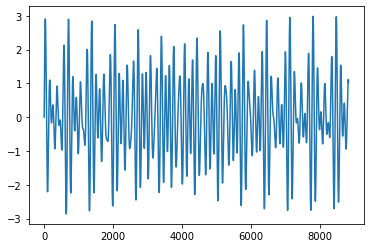

In [5]:
plt.plot(test_signal)
plt.show()

---
#  Convolution 

пробуем через np.convolve

сначала 2 функции для создания вейвлета, мало ли какой именно из них захочется поиграться

первая делает вейвлет по заданной частоте, вторая рассчитывает от scale по формуле фадеева при n0=440

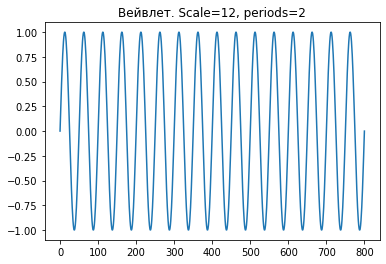

In [6]:
def make_wavelet(fc, periods):
    length = periods/fc
    x_vector = np.linspace(-length/2,length/2,int(SAMPLING_FREQUENCY*length))
    return np.sin(2*np.pi*fc*x_vector)

def conv_piano_wavelet(scale, periods):
    #center frequency базовой ноты. 440 - нота ля, 
    # по ней обычно настраивают инструменты
    n0_freq = 440
    
    #коэффициент масштабирования
    # 2^(-i/12), где i - положение ноты N_i по высоте относительно ноты N_0
    # i целое
    modifier = np.power(2, (-scale/12), dtype=np.float64) 
    
    #если построить вейвлет на [0,length], в нем будет {periods} периодов
    length = periods*modifier/n0_freq #seconds

    mother_wavelet = lambda t: np.sin(2*np.pi*n0_freq*(t/modifier))
    x = np.linspace(-length/2,length/2,int(SAMPLING_FREQUENCY*length))
    res = mother_wavelet(x)
    return res

f, ax = plt.subplots()
ax.plot(conv_piano_wavelet(scale=12, periods=16))
ax.set_title('Вейвлет. Scale=12, periods=2')
plt.show()

### Convolution. Сборная функция

нужно сделать цикл, который пробежит кучкой вейвлетов по данным. затем вывести картинку.

In [15]:
%%time
from scipy.signal import correlate
from scipy.ndimage import median_filter
from scipy.ndimage import maximum_filter

def my_cwt(data, scales):
    PERIODS = 16
    #каждая строчка - результат свертки для вейвлета с этим scale
    if type(scales) != list and type(scales) != np.ndarray:
        scales = [scales]
    cwt_result = np.zeros((len(scales), len(data))) 
    for i in range(len(scales)):
        wave = conv_piano_wavelet(scales[i], PERIODS)
        #если длина ноты (пусть и 16 периодов) больше длины сигнала, то ее там точно нет
        if len(wave)>len(cwt_result[i]):
            cwt_result[i] = [0]*len(cwt_result[i])
        else:
            cwt_result[i] = correlate(data, wave, mode='same', method='fft')
            modifier = np.power(abs(np.power(2, (-scales[i]/12), dtype=np.float64)), -0.5)
            cwt_result[i] *= modifier
    #return cwt_result
    filtered_cwt = np.zeros(cwt_result.shape)
    for line_num in range(len(cwt_result)):
        filtered_cwt[line_num] = median_filter(maximum_filter(abs(cwt_result[line_num]),401),401)
        local_threshold = max(filtered_cwt[line_num]) * 0.5
        filtered_cwt[line_num] = [item if item>local_threshold else 0 for item in filtered_cwt[line_num]]
    return filtered_cwt

widths = list(np.arange(-36,36.01))
cwt_result = my_cwt(test_signal,widths)

Wall time: 1.86 s


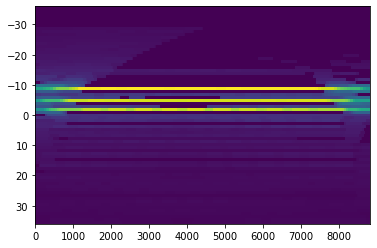

In [16]:
plt.imshow(cwt_result, aspect='auto', interpolation='none', 
            extent=[0, cwt_result.shape[1]-1, widths[-1], widths[0]])
plt.show()

вертикальный фильтр: если точка больше двух точек сверху и снизу, то она белая, иначе черная.

In [17]:
def local_vertical_maximum_filter(data):
    new_matrix = np.zeros(data.shape, dtype=int)
    for column_num in range(len(test_signal)):
        column = data[:,column_num]
        for cell_num in range(len(column)):
                if cell_num>1 and cell_num<(len(column)-3):
                    new_matrix[cell_num,column_num] = 1 if (column[cell_num]>column[cell_num-1] and
                                                            column[cell_num]>column[cell_num-2] and
                                                            column[cell_num]>column[cell_num+1] and
                                                            column[cell_num]>column[cell_num+2]) else 0
                elif cell_num<=1:
                    new_matrix[cell_num,column_num] = 1 if (column[cell_num]>column[cell_num+1] and
                                                            column[cell_num]>column[cell_num+2]) else 0
                elif cell_num>=(len(column)-3):
                    new_matrix[cell_num,column_num] = 1 if (column[cell_num]>column[cell_num-1] and
                                                            column[cell_num]>column[cell_num-2]) else 0
    return new_matrix

попробуем пройтись тем же фильтром по вертикали, что проходим по горизонтали

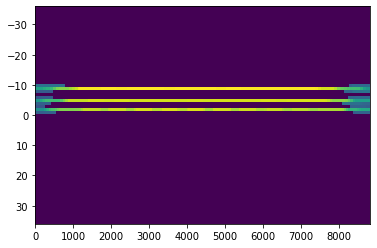

Wall time: 469 ms


In [20]:
%%time
def vertical_filter(data):
    new_matrix = np.zeros(data.shape)
    for column_num in range(len(test_signal)):
        local_threshold = max(data[:,column_num]) * 0.4
        new_matrix[:,column_num] = [item if item>local_threshold else 0 for item in data[:,column_num]]
    return new_matrix

trimmed_cwt = vertical_filter(cwt_result)
plt.imshow(trimmed_cwt, aspect='auto', interpolation='none',
            extent=[0, trimmed_cwt.shape[1]-1, widths[-1], widths[0]])
plt.show()

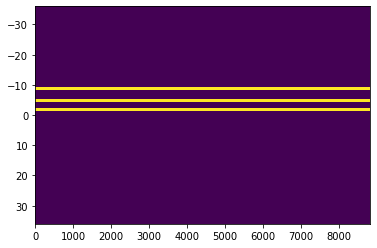

Wall time: 658 ms


In [19]:
%%time
bin_cwt = local_vertical_maximum_filter(trimmed_cwt)
plt.imshow(bin_cwt, aspect='auto', interpolation='none', 
            extent=[0, bin_cwt.shape[1]-1, widths[-1], widths[0]])
plt.show()

In [24]:
def safe_get(data,index):
    return data[max(min(len(data)-1,index),0)]

In [1]:
def count_frequency(scale):
    n0 = 440
    modificator = np.power(2, (-scale/12), dtype=np.float64)
    return round(n0/modificator,2)
print(count_frequency(0))

NameError: name 'np' is not defined

In [37]:
def note_noter(data):
    notes = {}
    signal_length = len(data[0])
    min_length = 700
    for line_num in range(len(data)):
        #На строке найдем индексы начала цепочек 
        # «единиц» (нота присутствует) и «нулей» (нота отсутствует).
        indexes = list(np.nonzero(np.r_[1, np.diff(data[line_num])[:-1]])[0])
        indexes.append(signal_length-1)
        #Получим длины цепочек повторений
        slices_lengths = list(abs(np.subtract(indexes[:-1], indexes[1:])))
        slices_signed = (([0, 1] if data[line_num][0]==0 else [1,0]) * int(len(indexes)/2))[:len(indexes)]
        idx = 0
        while idx<len(slices_signed):
            if slices_signed[idx] == 0 and slices_lengths[idx]<min_length:
                del(slices_signed[idx])
                del(slices_lengths[idx])
                del(indexes[idx])
                continue
            idx +=1
        idx = 1
        while idx<len(slices_signed):
            if slices_signed[idx] == 1 and slices_signed[idx-1]==1:
                slices_lengths[idx-1] += slices_lengths[idx]
                del(slices_signed[idx])
                del(slices_lengths[idx])
                del(indexes[idx])
                continue
            idx+=1
        for (sign, idx, length) in zip(slices_signed,indexes,slices_lengths):
            if sign==1 and length >= min_length: 
                if count_frequency(widths[line_num]) not in notes:
                    notes[count_frequency(widths[line_num])] = []
                notes[count_frequency(widths[line_num])].append([idx, length])
    return notes

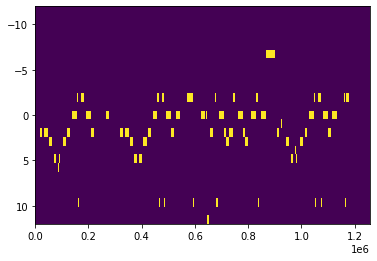

Wall time: 4.67 s


In [39]:
%%time
notes = note_noter(bin_cwt)
fixed_bin_cwt = np.zeros(bin_cwt.shape)
for line_num in range(len(widths)):
    if count_frequency(widths[line_num]) in notes:
        for note_data in notes[count_frequency(widths[line_num])]:
            end_point = note_data[0] + note_data[1]
            fixed_bin_cwt[line_num][note_data[0]:end_point] = [1]*note_data[1]
plt.imshow(fixed_bin_cwt, aspect='auto', interpolation='none',
            extent=[0, fixed_bin_cwt.shape[1]-1, widths[-1], widths[0]])
plt.show()

In [27]:
print('Исходные данные [начало ноты, длина]:')
for note_freq in sorted(notes_original.keys()):
        print(f'{note_freq} Hz: {notes_original[note_freq]}')
print('\nРезультат работы программы [начало ноты, длина]:')
for note_freq in notes.keys():
    print(f'{note_freq} Hz: {notes[note_freq]}')
print('\nРазница исходных данных и результатов')
for note_freq in notes.keys():
    print(f'{note_freq} Hz: {np.array(notes[note_freq]) - np.array(notes_original[note_freq])}')

Исходные данные [начало ноты, длина]:
261.63 Hz: [[0, 8821]]
329.63 Hz: [[0, 8821]]
369.99 Hz: [[17643, 1765]]
392 Hz: [[0, 8821]]
523.25 Hz: [[0, 8821], [17643, 1765]]
622.25 Hz: [[8822, 17643]]

Результат работы программы [начало ноты, длина]:
261.63 Hz: [[0, 8970]]
329.63 Hz: [[0, 8965]]
369.99 Hz: [[17378, 2259]]
392.0 Hz: [[0, 8873]]
523.25 Hz: [[0, 8925], [17351, 2032]]
622.25 Hz: [[8793, 17231]]

Разница исходных данных и результатов
261.63 Hz: [[  0 149]]
329.63 Hz: [[  0 144]]
369.99 Hz: [[-265  494]]
392.0 Hz: [[ 0 52]]
523.25 Hz: [[   0  104]
 [-292  267]]
622.25 Hz: [[ -29 -412]]


def reconstruct_signal(notes:dict, signal_length=None, origin=None):
    '''origin - массив с базовой нотой. если None, синтезируем синусоиды'''
    #если длина сигнала неизвестна, смотрим на последние ячейки в нотах, складываем в них начало ноты и ее длину, ищем максимальный результат - это длина сигнала
    signal_length = max([cell[0]+cell[1] for cell in [notes[note_freq][-1] for note_freq in notes.keys()]]) if signal_length==None else signal_length
    signal = np.zeros(signal_length, dtype=np.float64)
    time_array = np.arange(signal_length)

    if origin==None:
        for note_freq in notes.keys():
            for note_data in notes[note_freq]:
                end_point = note_data[0]+note_data[1]
                signal[note_data[0]:end_point] += np.sin(2*np.pi*note_freq*time_array[note_data[0]:end_point])
    return signal

reconstructed_signal = reconstruct_signal(notes)
time_array = np.linspace(0, stop_time, len(reconstructed_signal))
plt.plot(time_array, reconstructed_signal)
plt.show()

# Опыты на реальной ноте

(тут пока ничего нет, просто огрызок валяется, дайте ему настояться)

**TODO**: придумать хитрый фокус, чтобы брать фрагмент и аппроксимировать его, чтобы сумма равнялась 0 (по закону вейвлета).

возможное решение: посмотреть, как это делается в матлабе, спиздить алгоритм

from scipy.io.wavfile import read
music = read('audio/1note/piano-a_A_major.wav')
note = np.array(music[1], dtype=float)
note_1 = [item[0] for item in note] #first channel
note_2 = [item[1] for item in note] #second channel

note_1_cut = note_1[33000:36000]
plt.plot(note_1_cut)
plt.show()